<a href="https://colab.research.google.com/github/datxander/NLP/blob/main/Sentiment_classification_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
# Load the IMDB reviews dataset

dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Preview some examples
for text, label in train_dataset.take(1):
    print(f"Review: {text.numpy().decode('utf-8')}")
    print(f"Sentiment: {'Positive' if label.numpy() == 1 else 'Negative'}\n")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.OGT20L_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.OGT20L_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.OGT20L_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Sentiment: Negative



In [3]:
# Shuffle and batch the dataset
buffer_size = 10000
batch_size = 64

train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [4]:
# Text vectorization

# Vectorization layer definition
vocab_size = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

# Adapt this layer to the training data
train_text = train_dataset.map(lambda text, label: text)
vectorize_layer.adapt(train_text)

In [28]:
# Build classification model through NN

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid') # for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



In [38]:
# Training this model

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stop]
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9287 - loss: 0.1898 - val_accuracy: 0.8490 - val_loss: 0.3575
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9329 - loss: 0.1775 - val_accuracy: 0.8489 - val_loss: 0.3693
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9399 - loss: 0.1580 - val_accuracy: 0.8449 - val_loss: 0.3958
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9441 - loss: 0.1490 - val_accuracy: 0.8604 - val_loss: 0.3688
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9518 - loss: 0.1372 - val_accuracy: 0.8369 - val_loss: 0.4364
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9454 - loss: 0.1503 - val_accuracy: 0.8569 - val_loss: 0.4056


In [39]:
# Evaluate this model

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc: .2f}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8510 - loss: 0.3585
Test Loss: 0.35747283697128296, Test Accuracy:  0.85


In [35]:
# Try making predictions

sample_text = tf.constant(["This movie rocks"])
predictions = model.predict(sample_text)
print(f"Sentiment score: {predictions[0][0]: .4f}")
print(f"Prediction: {'Positive' if predictions[0][0]> 0.5 else 'Negative'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sentiment score:  0.7153
Prediction: Positive


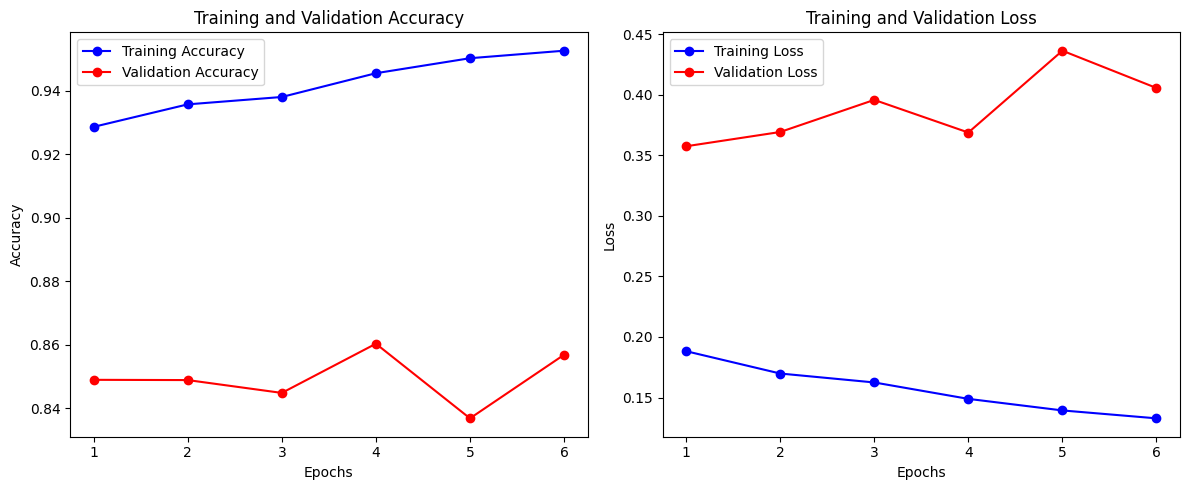

In [40]:
# Visualize training history

import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)
